# Monte Carlo Simulation

Now the goal is not to create only one sample and conduct one OLS estimation. We want to create many many random samples and conduct many many OLS estimations. The goal is to numerically simulate the distribution of the OLS estimator. 

In [ ]:
# loading modules
using LinearAlgebra
using Statistics
using Random
using Plots

In [ ]:
# defining composite types that
# serve as containers to store results

struct Parameters
    n::Int64
    beta_0::Float64
    beta_1::Float64
end

struct Sample
    x::Array{Float64,2}
    y::Array{Float64,1}
end

struct OLS_results
    bols::Array{Float64,1}
    se_hom::Array{Float64,1}
    se_het::Array{Float64,1}
    ci_hom::Array{Float64,1}
    ci_het::Array{Float64,1}
end

struct Simresults
    bols::Array{Float64,1}
    cilb::Array{Float64,1}
    ciub::Array{Float64,1}
end

# Defining useful functions

In [ ]:
"""
    sample(parms)

Creates one random sample according to linear model
Y = α + β X + e

Requires Parameters object as argument.

"""
function sample(parms::Parameters)

    # creating sample

    # exogenous variables: simply set as normal rvs
    X = [ones(parms.n, 1) randn(parms.n)]
    e = randn(parms.n) 

    # creating endogenous variables    
    Y = X*[parms.beta_0; parms.beta_1] + e;
    
    # returning Sample object
    Sample(X, Y)
    
end

In [ ]:
"""
    ols(X, Y)

Computes OLS estimate, its standard error, and the corresponding 95% confidence interval.

Requires Nx2 dimensional data matrix X, and Nx1 dimensional data vector Y as input.
"""

function ols(X::Array{Float64,2}, Y::Array{Float64,1})
    
    xxinv = inv(X'*X)
   
    bols = xxinv*X'*Y
    
    ehat = Y - X*bols;
    shat = ehat'*ehat/length(ehat);

    Omegahat_hom = shat[1]*inv(X'*X);
    Omegahat_het = xxinv * (X'*Diagonal(ehat.^2)*X) * xxinv;

    se_hom = diag(Omegahat_hom).^(0.5)
    se_het = diag(Omegahat_het).^(0.5)
    
    ci_hom = [bols[2] - 1.96*se_hom[2], bols[2] + 1.96*se_hom[2]]
    ci_het = [bols[2] - 1.96*se_het[2], bols[2] + 1.96*se_het[2]]
    
    # returning OLS_results object
    OLS_results(bols, se_hom, se_het, ci_hom, ci_het)

end

In [ ]:
"""
    simulate(parms, reps)

Creates #reps OLS estimates and the resulting confidence intervals.

The returned output can be seen as the simulated distributions.

"""
function simulate(parms::Parameters, reps::Int64=5000)
    
    b = zeros(reps) # collects all ols slope estimates
    lb = zeros(reps) # collects ci lower bounds
    ub = zeros(reps) # collects ci upper bounds    
    
    for r = 1:reps
        
        mysample = sample(parms)
        myresults = ols(mysample.x, mysample.y)
         
        b[r] = myresults.bols[2] 
        lb[r] = myresults.ci_het[1]
        ub[r] = myresults.ci_het[2]
        
    end
    
    # returning simulation result object
    Simresults(b, lb, ub)
    
end

# OLS simulation
Here I am going to plot the finite sample distribution and look at the simulated confidence intervals.

In [75]:
# setting parameters
# DGP is Y = beta_0 + beta_1 X + e
beta_0, beta_1 = 24, 8
N = 1000 # sample size
myparms = Parameters(N, beta_0, beta_1);

In [76]:
bols_dstn = simulate(myparms);

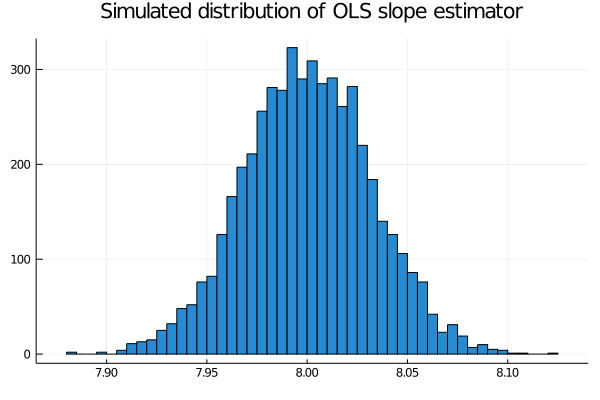

In [77]:
# finite sample distribution, it's just a histogram!
histogram(bols_dstn.bols, title="Simulated distribution of OLS slope estimator", label="", color="#268bd2")

In [73]:
savefig("simulated_distribution")

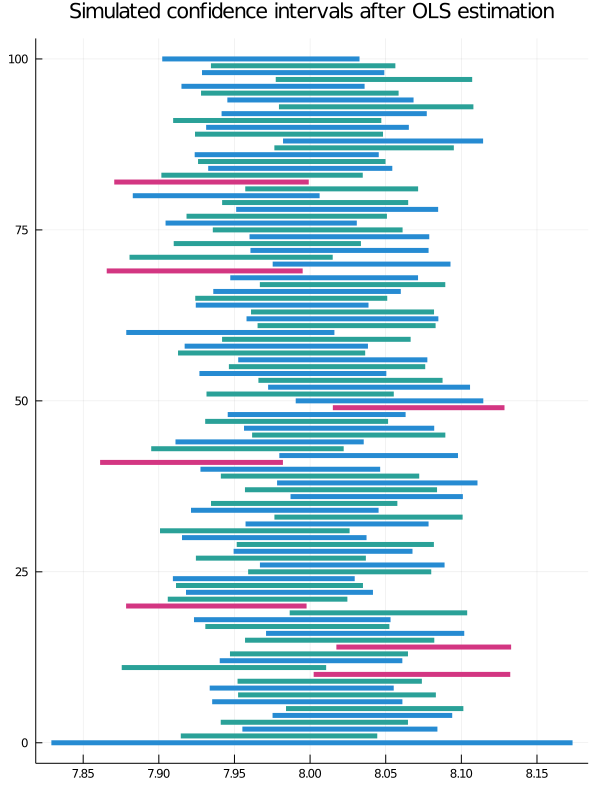

In [74]:
# primitive function to visualize the many confidence intervals we simulated
colsel = ["#268bd2", "#2aa198"]
i = 0
f(x) = i
plot(f,[minimum(bols_dstn.cilb),maximum(bols_dstn.ciub)], 
        title="Simulated confidence intervals after OLS estimation",
        lw=5, label="", linecolor="#268bd2", size=(600,800))

for i = 1:100 # don't plot too many ci's!

    f(x) = i
    if bols_dstn.cilb[i]>myparms.beta_1
        Plots.display(plot!(f, [bols_dstn.cilb[i], bols_dstn.ciub[i]], lw=5, label="", linecolor="#d33682"))
    elseif bols_dstn.ciub[i]<myparms.beta_1
        Plots.display(plot!(f, [bols_dstn.cilb[i], bols_dstn.ciub[i]], lw=5, label="", linecolor="#d33682"))
    else
        Plots.display(plot!(f, [bols_dstn.cilb[i], bols_dstn.ciub[i]], lw=5, label="", linecolor=colsel[isodd(i)+1]))
    end
    IJulia.clear_output(true) # needed to keep plot
        
end

savefig("simulated_confidence_intervals")